In [19]:
import os
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# Set constant
from datetime import datetime
NOW  = datetime.now().strftime("%m%d%Y_%H:%M%S")

# Prepare data

In [3]:
training_data = os.listdir('./data/training')


labels = []
for filename in training_data:
    label = filename.split('.')[0]
    if label == 'cat':
        labels.append(0)
    else:
        labels.append(1)

df = pd.DataFrame({
    'name': training_data,
    'labels': labels
})

In [4]:
testing_data = os.listdir('./data/testing')


test_df = pd.DataFrame({
    'name': testing_data,
})
number_of_test_sampless = test_df.shape[0]

### Change labels from int to string to fit requirements for ImageDataGenerator

In [5]:
df['labels'] = df['labels'].replace({0: 'cat', 1: 'dog'})


### Split training data into 75% training, and 25% validation

In [6]:
train_df, validate_df = train_test_split(df, test_size=0.25, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

# Data Generators

## Training

In [7]:
train_datagenerator = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagenerator.flow_from_dataframe(
    train_df, 
    "./data/training/", 
    x_col='name',
    y_col='labels',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=16
)

Found 18750 validated image filenames belonging to 2 classes.


## Validation

In [8]:
validation_datagenerator = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagenerator.flow_from_dataframe(
    validate_df, 
    "./data/training/", 
    x_col='name',
    y_col='labels',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=16
)

Found 6250 validated image filenames belonging to 2 classes.


## Testing

In [9]:
testing_datagenerator = ImageDataGenerator(rescale=1./255)
testing_generator = testing_datagenerator.flow_from_dataframe(
    test_df, 
    "./data/testing/", 
    x_col='name',
    y_col=None,
    class_mode=None,
    batch_size=16,
    target_size=(128, 128),
    shuffle=False
)

Found 12500 validated image filenames.


## Visualize example of generated training data

In [11]:
sample_df = train_df.sample(n=1).reset_index(drop=True)
sample_generator = train_datagenerator.flow_from_dataframe(
    sample_df, 
    "./data/training/",
    x_col='name',
    y_col='labels',
    target_size=(128, 128),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


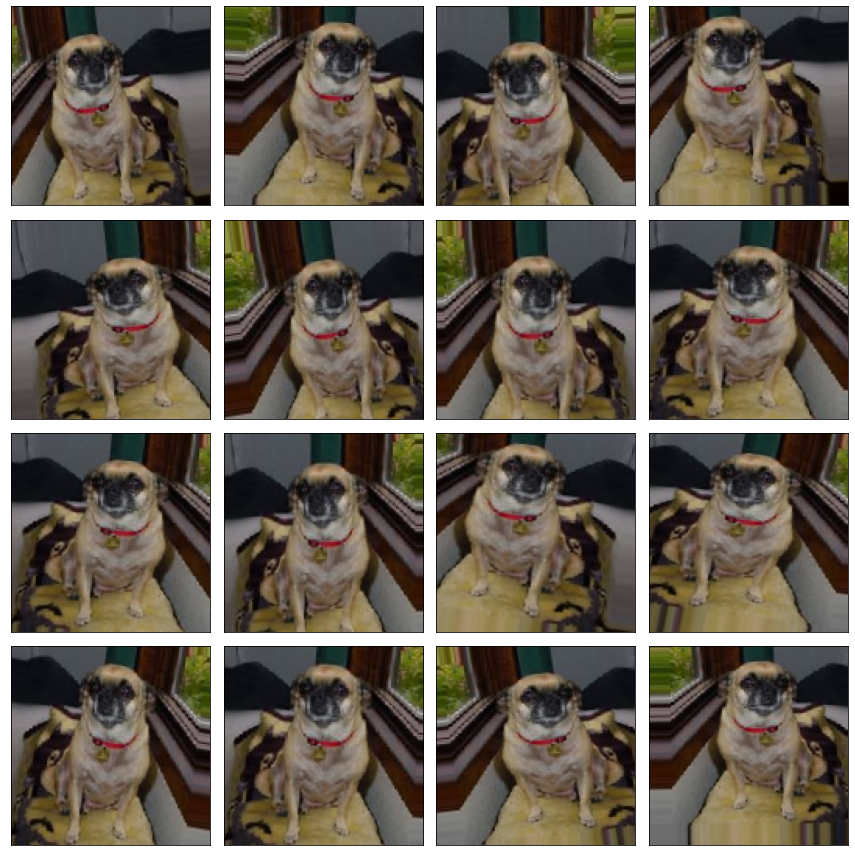

In [12]:
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    for X, Y in sample_generator:
        image = X[0]
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        break
plt.tight_layout()
plt.show()

# Training: fit model on training data

In [14]:
TOTAL_TRAINING_SIZE = train_df.shape[0]
TOTAL_VALIDATION_SIZE = validate_df.shape[0]
BATCH_SIZE = 16
EPOCHS = 50

## Introduce early stopping and handle plateauing

In [16]:
early_stopping = EarlyStopping(patience=5, verbose=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                        patience=2,
                                        verbose=True,
                                        factor=0.5,
                                        min_lr=1e-5)

In [ ]:
from models.cnn_model import CNNModel

model = CNNModel().model

history = model.fit(
            x=train_generator,
            epochs=EPOCHS,
            validation_data=validation_generator,
            validation_steps=TOTAL_VALIDATION_SIZE//BATCH_SIZE,
            steps_per_epoch=TOTAL_TRAINING_SIZE//BATCH_SIZE,
            callbacks=[early_stopping, reduce_learning_rate]
            )

In [ ]:
model.save_weights(f"cnn_model_{NOW}.h5")


In [22]:
# https://www.tensorflow.org/tutorials/images/classification#visualize_training_results
def tf_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(16, 9))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Testing: make predictions with trained model

In [ ]:
predict = model.predict(testing_generator, steps=np.ceil(number_of_test_samples/BATCH_SIZEs))

In [ ]:
# axis =-1 to get last column, which holds the predicitons
test_df['label'] = np.argmax(predict, axis=-1)